# Teaching notebook for total imaging newbies

In [1]:
import pathlib
import imageio
import numpy as np

ROOT_DIR = pathlib.Path('C:/Users/sinjy/jupyter_notebook/datasets')
DATA_DIR = ROOT_DIR / 'kaggle_datasets' / 'nuclei'
training_paths = (DATA_DIR / 'stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

## Dealing with color

In [2]:
print('Original image shape: {}'.format(im.shape))

from skimage.color import rgb2gray
im_gray = rgb2gray(im[:, :, :3])
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


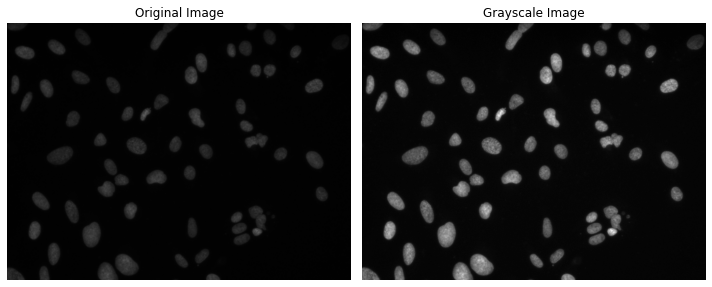

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

## Removing background

In [4]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

if np.sum(mask == 0) < np.sum(mask == 1):
    mask = np.where(mask, 0, 1)

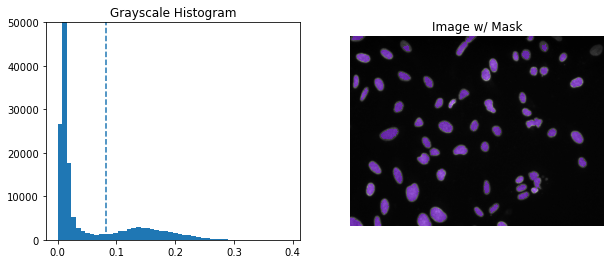

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0, 50000])
plt.title('Grayscale Histogram')

plt.subplot(1, 2, 2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

## Deriving individual masks for each object

In [6]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


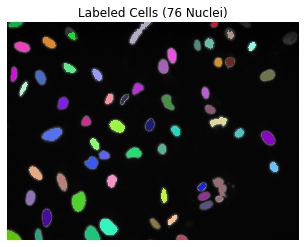

In [7]:
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [11]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected'.format(nlabels))

Label 4 is too small! Setting to 0
Label 5 is too small! Setting to 0
Label 7 is too small! Setting to 0
Label 8 is too small! Setting to 0
Label 9 is too small! Setting to 0
Label 10 is too small! Setting to 0
Label 14 is too small! Setting to 0
Label 15 is too small! Setting to 0
Label 16 is too small! Setting to 0
Label 19 is too small! Setting to 0
Label 21 is too small! Setting to 0
Label 22 is too small! Setting to 0
Label 23 is too small! Setting to 0
Label 60 is too small! Setting to 0
Label 61 is too small! Setting to 0
Label 72 is too small! Setting to 0
There are now 60 separate components / objects detected


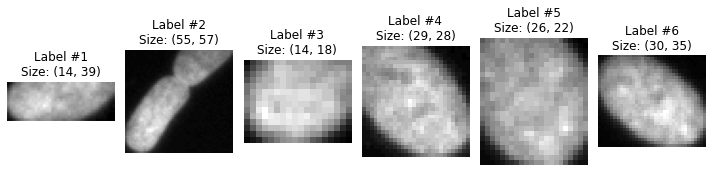

In [12]:
fig, axes = plt.subplots(1, 6, figsize=(10, 6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

In [13]:
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

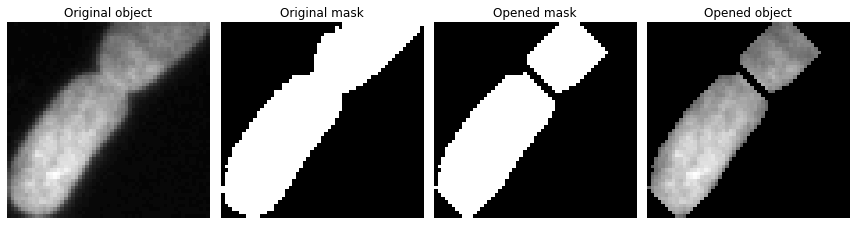

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices] * cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Convert each labeled object to Run Length Encoding

In [21]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1):
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


## Combine it into a single function

In [22]:
import pandas as pd

def analyze_image(im_path):
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im[:, :, :3])
    
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    return im_df

def analyze_list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    return all_df

In [23]:
testing = (DATA_DIR / 'stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 8 45359 11 45614 13 45869 14 46124 15 46...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 6 50534 10 50789 12 51043 14 51299 15 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10894 3 11147 7 11401 10 11656 12 11911 13 121...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31885 11 32139 14 32394 16 32649 17 32...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50843 2 51097 6 51351 9 51605 11 51860 12 5211...


In [24]:
df.to_csv(ROOT_DIR / 'kaggle_predict' / 'submission.csv', index=None)